Make sure you fill your name and NetID below:

In [131]:
NAME = "Malav Doshi"
NET_ID = "md1378"

---

---
# Assignment 3: RNN, LSTM, Attention, and Transformers

In this assignment, you will implement neural machine translation (NMT) models using:

1. RNNs
2. LSTMs and LSTMs with attention
3. Transformers.

As in the previous assignments, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
x = 3.7
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.


## Setup

First let's import some libraries that will be useful in this assignment.


In [132]:
import zipfile
import matplotlib.pyplot as plt
import random
import collections
import numpy as np
import zipfile
import torch
import os
import torch.nn as nn
import torch.nn.functional as F

def seed(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)

Make sure you are using the GPU.

In [133]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

Please set GPU via Edit -> Notebook Settings.


For this assignment, we will use an English-to-French dataset. As shown below, the dataset contains multiple lines each of which has an English sentence and its French translation separated by a tab. In this problem, since English is translated to French, English is the source language and French is the target language. Note that each text sequence is of variable lengnth and can be just one sentence or a paragraph of multiple sentences.

In [134]:
def download_if_not_exist(file_name):
  
  if not os.path.exists(file_name):
    import urllib.request
    DATA_URL = 'https://download.pytorch.org/tutorial/data.zip'

    file_name, _ = urllib.request.urlretrieve(DATA_URL, './data.zip')
    
  return file_name

def read_raw(file_name):
  file_name = download_if_not_exist(file_name)
  
  with zipfile.ZipFile(file_name, 'r') as fzip:
    raw_text = fzip.read(file_name.split('.')[-2][1:] + '/eng-fra.txt').decode('utf-8')
  return raw_text

In [135]:
raw_text = read_raw('./data.zip')
print(raw_text[:200])

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !
Wait!	Attends !
Wait!	Attendez !
I see.	Je comprends.


Next we'll do some preprocessing on this raw text. We need to replace special symbols (non-breaking spaces) with spaces, convert all characters to lower case, and insert a space between words and punctuation marks.

In [136]:
def preprocess_raw(text):
  text = text.replace('\u202f', ' ').replace('\xa0', ' ')
  out = ''
  for i, char in enumerate(text.lower()):
    if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
      out += ' '
    out += char
  return out

We further split the source-target pairs into a source list and a target list. We use word-level tokenization here. 

In [137]:
def split_source_target(text, max_len):
  source, target = [], []
  for i, line in enumerate(text.split('\n')):
    if i > 5000: # we only use 5000 pairs of translation
      break
    parts = line.split('\t')
    if len(parts) == 2:
      src_tokens = parts[0].split(' ')
      tgt_tokens = parts[1].split(' ')
      if (len(src_tokens) <= max_len) and (len(tgt_tokens) <= max_len):
        source.append(src_tokens)
        target.append(tgt_tokens)
  return source, target

In [138]:
def prepare_data(raw_text, max_len=10000):
  text = preprocess_raw(raw_text)
  source, target = split_source_target(text, max_len)
  return source, target

source, target = prepare_data(raw_text)

Using the whole dataset takes too much memory, and it is hard to train with a large vocabulary. Thus, we will filter out some words by looking at the statistical properties of the dataset.

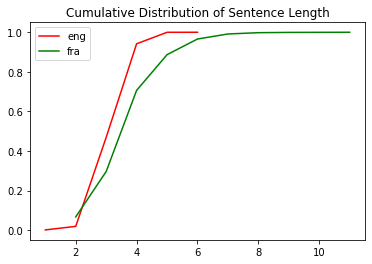

In [139]:
def len_dis(text):
  lens = [len(line) for line in text]
  len_counter = collections.Counter(lens)

  lens = np.array(list(len_counter.keys()))
  sort_idx = np.argsort(lens)
  lens_sort = lens[sort_idx]
  len_counts = np.array(list(len_counter.values()))
  len_counts_sort = len_counts[sort_idx]
  p = np.cumsum(len_counts_sort) / len_counts_sort.sum()
  return p, lens_sort
  
src_p, src_lens_sort = len_dis(source)
tgt_p, tgt_lens_sort = len_dis(target)
plt.plot(src_lens_sort, src_p, 'r-', label='eng')
plt.plot(tgt_lens_sort, tgt_p, 'g-', label='fra')
plt.title('Cumulative Distribution of Sentence Length')
plt.legend()
plt.show()

From the above plots, we can see that more than 90% of the sentences have a length of less than 8. Thus, we can filter out sentences of length greater than 8. We also filter out words that occur less than 5 times in the corpus.

In [140]:
# hyper-param
MAX_LEN = 8
MIN_FREQ = 5

### Build Vocabulary

Each word needs a unique index, and the words that have been filtered out need a special token to represent them. The following class Vocab is used to build the vocabulary. Some basic helper functions or dictionaries are also provided:
- Dictionary word2index: Convert word string into index: 
- Dictionary index2word: Convert index into word string
- helper function _build_vocab(): Build dictionaries for converting from words to indices and vice versa
- Word Counter, num_word: Record the total number of unique tokens in the vocabulary 
    
There are 4 special tokens added in the vocabulary:
- 'pad': padding token. Sentences shorter than MAX_LEN is padded by this symbol to make the length to MAX_LEN
- 'bos': beginning of sentence. This indicates the beginning of a sentence
- 'eos': end of sentence. This indicates the end of a sentence
- 'unk': unknown word. This represents words that have been filtered out (words that are not in the vocabulary)

In [141]:
class Vocab():
  def __init__(self, name, tokens, min_freq):
    self.name = name
    self.index2word = {
      0: 'pad',
      1: 'bos',
      2: 'eos',
      3: 'unk'
    }
    self.word2index = {v: k for k, v in self.index2word.items()}
    self.num_word = 4
    token_freq = collections.Counter(tokens)
    tokens = [token for token in tokens if token_freq[token] >= MIN_FREQ]
    self._build_vocab(tokens)
    
  def _build_vocab(self, tokens):
    for token in tokens:
      if token not in self.word2index:
        self.word2index[token] = self.num_word
        self.index2word[self.num_word] = token
        self.num_word += 1
        
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.word2index.get(tokens, self.word2index['unk'])
    else:
      return [self.__getitem__(token) for token in tokens]

### Build Dataset

The dataset pipeline involves the following steps:
- For target language, every sentence will be 'sandwiched' with the 'bos' token and the 'eos' token.
- Every sentence that has a length less than MAX_LEN will be padded to the MAX_LEN with the *padding_token*.
- The dataset should return the converted tensor and the corresponding valid length before padding.
- We use the Pytorch *DataLoader* API to build the dataset generator.

For the purposes of this assignment, we will train and evaluate on only the training data. This isn't ideal because we do not know if we are  overfitting to the training data, but it is fine for instructional purposes. In practice (eg. for your projects), you should make sure to split your data into training/validation/test datasets.

In [142]:
def build_vocab(name, tokens, min_freq):
  tokens = [token for line in tokens for token in line]
  return Vocab(name, tokens, min_freq)

def build_vocabs(lang_src, lang_tgt, src_text, tgt_text):
  vocab_src = build_vocab(lang_src, src_text, MIN_FREQ)
  vocab_tgt = build_vocab(lang_tgt, tgt_text, MIN_FREQ)
  return vocab_src, vocab_tgt

def pad(line, padding_token):
  return line + [padding_token] * (MAX_LEN + 2 - len(line))

def build_tensor(text, lang, is_source):
  lines = [lang[line] for line in text]
  if not is_source:
    lines = [[lang['bos']] + line + [lang['eos']] for line in lines]
  array = torch.tensor([pad(line, lang['pad']) for line in lines])
  valid_len = (array != lang['pad']).sum(1)
  return array, valid_len

def load_data_nmt(batch_size=2):
  lang_eng, lang_fra = build_vocabs('eng', 'fra', source, target)
  src_array, src_valid_len = build_tensor(source, lang_eng, True)
  tgt_array, tgt_valid_len = build_tensor(target, lang_fra, False)
  train_data = torch.utils.data.TensorDataset(
    src_array, src_valid_len, tgt_array, tgt_valid_len)
  print(train_data[0])
  train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
  return lang_eng, lang_fra, train_iter


source, target = prepare_data(raw_text, max_len=MAX_LEN)
vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size=2)
print('Vocabulary size of source language: {}'.format(vocab_eng.num_word))
print('Vocabulary size of target language: {}'.format(vocab_fra.num_word))
print('Total number of sentence pairs: {}'.format(len(source)))

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
Vocabulary size of source language: 433
Vocabulary size of target language: 420
Total number of sentence pairs: 4990


## Sequence to Sequence with RNN (baseline)

In this section, we provide the implementation of the seq2seq RNN baseline model. You do not need to implement any code in this section, but you should read and understand what the code is doing because you will need to implement something similar in subsequent sections. The following figure highlights the architecture of the seq2seq model. An encoder RNN encodes the input sequence into its hidden state, and passes the last hidden state to the decoder RNN. The decoder generates the target sequence.

Implementation Details:

- Embedding: We have represented each word with an integer or one-hot vector. We need an embedding layer to map an input word to its embedding vector.
- Encoder: A vanilla RNN is used to encode a source sequence. The final hidden state is returned as output and passed to the decoder RNN.
- Decoder: Another vanilla RNN is implemented to generate the target sequence. The hidden state is initialized with the last hidden state from the encoder.
- Encoder-Decoder: The class NMTRNN is built by combining the encoder and the decoder, and yields the loss and predictions.
- Loss: We have padded all sentences so that they have the same MAX_LEN. Thus, when we compute the loss, the loss from those padding_tokens should be masked out.

<div>
<img src="https://raw.githubusercontent.com/dsgiitr/d2l-pytorch/24e89824c154c2afc419c5dadec9622e490b99bb/img/seq2seq.svg" width="600"/>
</div>
Image source: https://github.com/dsgiitr/d2l-pytorch/blob/master/img/seq2seq.svg

In [143]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(Encoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of the hidden state of vanilla RNN
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim) # embedding layer
    self.enc = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.hidden_size = hidden_size
    
  def forward(self, sources, valid_len):
    """
    Inputs:
      source: tensor of size (N, T), where N is the batch size, T is the length of the sequence(s)
      valid_len: tensor of size (N,), indicating the valid length of sequence(s) (the length before padding)
    """
    word_embedded = self.embedding(sources)
    N = word_embedded.shape[0]
    
    h = sources.new_zeros(1, N, self.hidden_size).float() # initialize hidden state with zeros
    
    o, h = self.enc(word_embedded, h)
    
    return o[np.arange(N), valid_len] # return the hidden state of the valid last time step

class Decoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(Decoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of the hidden state of vanilla RNN
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.enc = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.output_emb = nn.Linear(hidden_size, vocab_size)
    self.hidden_size = hidden_size
    
  def forward(self, h, target):
    word_embedded = self.embedding(target)
    N, T = word_embedded.shape[:2]
    
    o, h = self.enc(word_embedded, h.view(1,N,self.hidden_size))
    pred = self.output_emb(o)
    return pred, h

class NMTRNN(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, hidden_size):
    super(NMTRNN, self).__init__()
    self.enc = Encoder(src_vocab_size, embedding_dim, hidden_size)
    self.dec = Decoder(tgt_vocab_size, embedding_dim, hidden_size)
    
  def forward(self, src, src_len, tgt, tgt_len):
    h = self.enc(src, src_len)
    T = tgt.shape[1]
    
    pred, _ = self.dec(h, tgt)
    loss = 0
    for t in range(T-1):
      # target sequence should shift by one time-step, because we are predicting the next word
      # notice the `ignore_index` parameter is set to 0, which is for the `pad` token
      loss = loss + F.nll_loss(F.log_softmax(pred[:, t]), tgt[:, t+1], ignore_index=0)

    return loss, pred.argmax(dim=-1)

  def predict(self, src, src_len, tgt, tgt_len):
      """
      When predicting a sequence given the 'bos' token, the input for the next step is the predicted
      token from the previous time step.
      """
      h = self.enc(src, src_len)

      inputs = tgt[:, :1]
      preds = []
      for t in range(MAX_LEN+1): # plus the 'eos' token
        pred, h = self.dec(h, inputs)
        preds.append(pred)
        inputs = pred.argmax(dim=-1)
        
      pred = torch.cat(preds, dim=1).argmax(dim=-1)
      return pred
        

In [144]:
def train_rnn(net, train_iter, lr, epochs, device):
  # training
  net = net.to(device)

  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  loss_list = []
  print_interval = len(train_iter)
  total_iter = epochs * len(train_iter)
  for e in range(epochs):
    net.train()
    for i, train_data in enumerate(train_iter):
      train_data = [ds.to(device) for ds in train_data]

      loss, pred = net(*train_data)

      #loss_list.append(loss.mean().detach())
      loss_list.append(loss.mean().detach().cpu())
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()

      step = i + e * len(train_iter)
      if step % print_interval == 0:
        print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.mean().detach()))
        print('pred:\t {}\n'.format(pred[0].detach().cpu()))
        print('tgt:\t {}\n'.format(train_data[2][0][1:].cpu()))
  return loss_list

seed(1)
batch_size = 32
lr = 1e-3
epochs = 50

embedding_dim = 250
hidden_size = 128

vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)
rnn_net = NMTRNN(vocab_eng.num_word, vocab_fra.num_word, embedding_dim, hidden_size)

rnn_loss_list = train_rnn(rnn_net, train_iter, lr, epochs, device)


(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
iter 0 / 7800	Loss:	41.284470
pred:	 tensor([146,  65, 349,  53,   3, 330,  52, 330, 330, 330])

tgt:	 tensor([ 3, 11,  2,  0,  0,  0,  0,  0,  0])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


iter 156 / 7800	Loss:	11.373285
pred:	 tensor([14,  3,  3, 11,  2, 11,  3,  3,  3,  3])

tgt:	 tensor([15, 89,  3, 11,  2,  0,  0,  0,  0])

iter 312 / 7800	Loss:	10.170559
pred:	 tensor([ 14, 164,   3,  11,  11,   2,  11,   3,   3,   3])

tgt:	 tensor([ 48,  49, 113, 282,  11,   2,   0,   0,   0])

iter 468 / 7800	Loss:	9.460752
pred:	 tensor([ 3,  3, 11,  3, 11,  2, 11,  3,  3, 11])

tgt:	 tensor([36,  3, 37,  3,  5,  2,  0,  0,  0])

iter 624 / 7800	Loss:	7.220555
pred:	 tensor([36,  3,  3, 11,  2, 11,  3,  3,  3,  3])

tgt:	 tensor([36,  9, 88, 11,  2,  0,  0,  0,  0])

iter 780 / 7800	Loss:	7.546277
pred:	 tensor([14, 28,  3, 11,  2, 11,  3, 11, 11, 11])

tgt:	 tensor([14, 28,  3, 11,  2,  0,  0,  0,  0])

iter 936 / 7800	Loss:	7.727297
pred:	 tensor([ 14,  28,   3, 227,  37,   3,  11,   2,  11,   3])

tgt:	 tensor([ 14,  28,  35, 227,  37,   3,  11,   2,   0])

iter 1092 / 7800	Loss:	6.481419
pred:	 tensor([171, 342,   3,  11,   2,  11,   3,  11,  11,  11])

tgt:	 tensor([171, 34

### RNN Loss Curve

Plot the loss curve over time.

Text(0.5, 1.0, 'Loss Curve of Baseline')

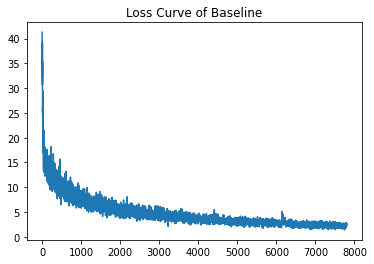

In [145]:
# save the loss curve figure in a file for the report
plt.plot(np.arange(len(rnn_loss_list)), rnn_loss_list)
plt.title('Loss Curve of Baseline')


### Prediction Accuracy

Print out 5 prediction samples, and calculate the prediction accuracy over the training dataset. You will see an accuracy of over 70%.

In [146]:
def comp_acc(pred, gt, valid_len):
  N, T_gt = gt.shape[:2]
  _, T_pr = pred.shape[:2]
  assert T_gt == T_pr, 'Prediction and target should have the same length.'
  len_mask = torch.arange(T_gt).expand(N, T_gt)
  len_mask = len_mask < valid_len[:, None]
  
  pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
  pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
  return pred_acc
  
def evaluate_rnn(net, train_iter, device):
  acc_list = []
  for i, train_data in enumerate(train_iter):
    train_data = [ds.to(device) for ds in train_data]

    pred = net.predict(*train_data)

    pred_acc = comp_acc(pred.detach().cpu(), train_data[2].detach().cpu()[:, 1:], train_data[3].cpu())
    acc_list.append(pred_acc)
    if i < 5:# print 5 samples from 5 batches
      pred = pred[0].detach().cpu()
      pred_seq = []
      for t in range(MAX_LEN+1):
        pred_wd = vocab_fra.index2word[pred[t].item()] 
        if pred_wd != 'eos':
          pred_seq.append(pred_wd)

      print('pred:\t {}\n'.format(pred_seq))
      print('tgt:\t {}\n'.format([vocab_fra.index2word[t.item()] for t in train_data[2][0][1:].cpu()]))

  print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))
  
seed(1)
batch_size = 32

vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)

evaluate_rnn(rnn_net, train_iter, device)

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
pred:	 ['unk', '.', '.', '.', '.']

tgt:	 ['unk', '!', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['je', "t'en", 'dois', 'une', '.', '.', '.']

tgt:	 ['je', "t'en", 'dois', 'une', '.', 'eos', 'pad', 'pad', 'pad']

pred:	 ['est-il', 'unk', '?', '?', '.', '.']

tgt:	 ['est-il', 'unk', '?', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['je', 'suis', 'unk', '.', '.', '.']

tgt:	 ['je', 'suis', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['unk', 'à', 'qui', 'que', 'ce', 'soit', '!', '?']

tgt:	 ['demande', 'à', 'unk', 'qui', '!', 'eos', 'pad', 'pad', 'pad']

Prediction Acc.: 0.7143


## Sequence to Sequence with LSTM and Attention

Now let's try to improve our model by using an LSTM and the attention mechanism.


### LSTM

LSTMs eliminate the gradient explosion/vanishing problem. Its state and gate update at each time step can be summarized as follows:

$$
\begin{align*}
&\text{State Update} &&& C_t &= F_t \odot C_{t-1} + I_t \odot \tilde{C}_t \\
&\text{Hidden States} &&& H_t &= O_t \odot \text{tanh}(C_t) \\
&\text{Proposal} &&& \tilde{C}_t &= \text{tanh}( X_tW_{xc} + H_{t-1}W_{hc} + b_c ) \\
&\text{Input Gate} &&& I_t &= \sigma( X_tW_{xi} + H_{t-1}W_{hi} + b_i ) \\
&\text{Forget Gate} &&& F_t &= \sigma( X_tW_{xf} + H_{t-1}W_{hf} + b_f ) \\
&\text{Output Gate} &&& O_t &= \sigma( X_tW_{xo} + H_{t-1}W_{ho} + b_o ) \\
\end{align*}
$$

Implement the LSTM class below. In particular,
-  Complete the initialization function *init_params()*. Weights should be initialized using `torch.randn` multiplied with a scale of 0.1. Biases should be initialized to 0.
- Complete the function *lstm()* which performs the feed-forward pass of LSTM. **Do not** use `nn.LSTM` or `nn.LSTMCell` in your implementation.

In [147]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, device):
    super(LSTM, self).__init__()
    self.device = device
    self.params = nn.ParameterList(self.init_params(input_size, hidden_size))
    """
    Inputs:
      input_size: int, feature dimension of input sequence
      hidden_size: int, feature dimension of hidden state
      device: torch.device()
    """
  
  def init_params(self, input_size, hidden_size):
    """
    Inputs:
      input_size: int, feature dimension of input sequence
      hidden_size: int, feature dimension of hidden state
      
    Outputs:
      Weights for proposal: W_xc, W_hc, b_c
      Weights for input gate: W_xi, W_hi, b_i
      Weights for forget gate: W_xf, W_hf, b_f
      Weights for output gate: W_xo, W_ho, b_o
    """
    W_xc, W_hc, b_c = None, None, None
    W_xi, W_hi, b_i = None, None, None
    W_xf, W_hf, b_f = None, None, None
    W_xo, W_ho, b_o = None, None, None
    ##############################################################################
    # TODO: Initialize the weights and biases. The result will be stored in 
    # `params` below. Weights should be initialized using `torch.randn` multiplied 
    # with the scale (0.1). Biases should be initialized to 0.
    ##############################################################################
    # Replace "pass" statement with your code
    # b_c, b_i, b_f, b_o = torch.zeros(hidden_size, device = self.device), torch.zeros(hidden_size, device = self.device), torch.zeros(hidden_size, device = self.device), torch.zeros(hidden_size, device = self.device)
    # W_hc, W_hi, W_hf, W_ho, = 0.1*torch.randn(size = (hidden_size, hidden_size), device = self.device), 0.1*torch.randn(size = (hidden_size, hidden_size), device = self.device), 0.1*torch.randn(size = (hidden_size, hidden_size), device = self.device), 0.1*torch.randn(size = (hidden_size, hidden_size), device = self.device)
    # W_xc, W_xi, W_xf, W_xo, =  0.1*torch.randn(size = (input_size, hidden_size), device = self.device), 0.1*torch.randn(size = (input_size, hidden_size), device = self.device), 0.1*torch.randn(size = (input_size, hidden_size), device = self.device), 0.1*torch.randn(size = (input_size, hidden_size), device = self.device)
    self.hidden_size = hidden_size
    #source weights
    W_xc = nn.Parameter(0.1 * torch.randn(input_size, hidden_size))
    W_xi = nn.Parameter(0.1 * torch.randn(input_size, hidden_size))
    W_xf = nn.Parameter(0.1 * torch.randn(input_size, hidden_size))
    W_xo = nn.Parameter(0.1 * torch.randn(input_size, hidden_size))

    #hidden weights
    W_hc = nn.Parameter(0.1 * torch.randn(hidden_size, hidden_size))
    W_hi = nn.Parameter(0.1 * torch.randn(hidden_size, hidden_size))
    W_hf = nn.Parameter(0.1 * torch.randn(hidden_size, hidden_size))
    W_ho = nn.Parameter(0.1 * torch.randn(hidden_size, hidden_size))

    #Biases
    b_c = nn.Parameter(0.1 * torch.zeros((hidden_size)))
    b_i = nn.Parameter(0.1 * torch.zeros((hidden_size)))
    b_f = nn.Parameter(0.1 * torch.zeros((hidden_size)))
    b_o = nn.Parameter(0.1 * torch.zeros((hidden_size)))

    params = [W_xc, W_hc, b_c, W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o]
    return params

  
  def lstm(self, X, state):
    """
    Inputs:
      X: tuple of tensors (src, src_len). src, size (N, D_in) or (N, T, D_in), where N is the batch size,
        T is the length of the sequence(s). src_len, size of (N,), is the valid length for each sequence.
        
      state: tuple of tensors (h, c). h, size of (N, hidden_size) is the hidden state of LSTM. c, size of 
            (N, hidden_size), is the memory cell of the LSTM.
      
    Outputs:
      o: tensor of size (N, T, hidden_size). Contains the output features (the hidden state H_t) for each t.
      state: the same as input state. Contains the hidden state H_T and cell state C_T for the last timestep T.
    """
    
    src, src_len = X
    h, c = state

    #Check for T dim
    if len(src.shape) == 2:
      src = src.unsqueeze(1)

    N, T, D_in = src.shape
    W_xc, W_hc, b_c, W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o = self.params
    o = []
    ##############################################################################
    # TODO: Implement the forward pass of the LSTM.
    ##############################################################################
    # forget_gate = lambda X_t : torch.sigmoid(torch.matmul(h, W_hf)+torch.matmul(X_t, W_xf)+b_f)
    # input_gate =  lambda X_t: torch.sigmoid(torch.matmul(X_t, W_xi) +torch.matmul(h, W_hi)+b_i)
    # output_gate =  lambda X_t: torch.sigmoid(torch.matmul(X_t, W_xo) +torch.matmul(h, W_ho)+b_o)

    # for t in range(T):
    #   x_t = src[:, t, :]
    #   output = output_gate(x_t)
    #   ctl = torch.tanh(torch.matmul(x_t, W_xc)+ torch.matmul(h, W_hc)+b_c)
    #   c = forget_gate(x_t)*c+input_gate(x_t)*ctl
    #   h = output*torch.tanh(c)
    #   o.append(h.unsqueeze(0))
    # o = torch.cat(o, dim = 0).transpose(0,1).contiguous()
    # o = torch.squeeze(o, dim = 0)
    # o = o.permute(1, 0, 2)

    # for t in range(T):
    #   x = src[:,t,:]
    #   forget_gate = torch.sigmoid(x @ W_xf + h @ W_hf + b_f)
    #   input_gate = torch.sigmoid(x @ W_xi + h @ W_hf + b_i)
    #   output_gate = torch.sigmoid(x @ W_xo + h @ W_ho + b_o)
    #   C_tilda = torch.tanh(x @ W_xc + h @ W_hc + b_c)
    #   c = forget_gate * c + input_gate * C_tilda
    #   h = output_gate * torch.tanh(c)
    #   o.append(h.unsqueeze(0))
    # hidden_seq = torch.cat(o, dim=0)
    # hidden_seq = hidden_seq.permute(1, 0, 2)
    # o = o[np.arange(N), src_len]
    # # END OF YOUR CODE

    # state = (h, c)
    # return o, state
    # # END OF YOUR CODE

    # state = (h, c)

    for t in range(T):
            x_t = src[:, t, :]

            #Input Gate
            i_t = torch.sigmoid(torch.matmul(x_t, W_xi) + torch.matmul(h, W_hi) + b_i)

            #Forget gate
            f_t = torch.sigmoid(torch.matmul(x_t, W_xf) + torch.matmul(h, W_hf) + b_f)

            #Memory Cell: C_bar
            g_t = torch.tanh(torch.matmul(x_t, W_xc) + torch.matmul(h, W_hc) + b_c)

            #Output Gate
            o_t = torch.sigmoid(torch.matmul(x_t, W_xo) + torch.matmul(h, W_ho) + b_o)

            valid_mask = (src_len > t).float()[:,None]
            update_c = f_t * c + i_t * g_t
            h = o_t * torch.tanh(update_c)

            c = (1 - valid_mask) * c + (valid_mask*update_c)

            c = update_c
            
            # o.append(h.unsqueeze(0))
            o.append(h)
            # print(o.size())
    o = torch.stack(o, dim = 1)
    # o = torch.cat(o, dim = 0).transpose(0,1).contiguous()
    # o = torch.squeeze(o, dim = 0)
    # o = o.permute(1, 0, 2)
    # o = torch.cat(o, dim=0)
    # o = o.transpose(0, 1).contiguous()
    return o, (h,c)
  
  def forward(self, inputs, state):
    return self.lstm(inputs, state)

Check that your output has the correct shape. You should see:

```
torch.Size([12, 8, 5])
torch.Size([12, 5])
torch.Size([12, 5])
```

In [148]:
test_lstm = LSTM(10, 5, torch.device('cpu'))
test_src = torch.ones(12, 8, 10)
test_src_len = torch.ones(12) * 8
test_h = torch.zeros(12, 5).float()
test_c = torch.zeros(12, 5).float()

test_o, test_state = test_lstm((test_src, test_src_len), (test_h, test_c))

print(test_o.shape)
print(test_state[0].shape)
print(test_state[1].shape)


torch.Size([12, 8, 5])
torch.Size([12, 5])
torch.Size([12, 5])


### Attention Mechanism

Another improvement we can make to our model is the Attention Mechanism. An example illustrating why applying attention mechanisms can improve the performance is shown in the picture below. An English sentence and its Chinese is visualized and aligned into blue boxes and red boxes, respectively. It can be seen that the Chinese character '她' has a long distance from its English counterpart, 'she'. Since only the final hidden state is passed to the decoder, it's hard for the baseline model to 'attend' to information a long time ago.

<div>
<img src="https://lilianweng.github.io/lil-log/assets/images/encoder-decoder-example.png" width="600"/>
</div>
Image source: https://lilianweng.github.io/lil-log/assets/images/encoder-decoder-example.png

- **Attention**

    Given a query, $\mathbf{q} \in R^{d_q}$, and a set of $N$ (key, value) pairs, $\{ \mathbf{k}_i, \mathbf{v}_i\}^N$ where $k_i \in R^{d_k}$ and $v_i \in R^{d_v}$, the attention mechanism computes a weighted sum of values based on the normalized score obtained from the query and each key:
    $$
    \begin{align*}
    a_i &= \alpha(\mathbf{q}, \mathbf{k_i}) \\
    \mathbf{a} &= [a_1, ..., a_n] \\
    \mathbf{b} &= \text{softmax}(\mathbf{a}) \\
    \mathbf{o} &= \mathbf{b} \cdot \mathbf{V}\text{, where } \mathbf{V} = \{\mathbf{v}_i\}^N
    \end{align*}
    $$
    The $\alpha()$ function, which maps two vectors into a scalar, is the score function that can be chosen from a wide range of functions: e.g. the cosine function, dot-product function, scaled dot-product funtion and etc.


- **Masked Softmax**

For our machine translation task, the inputs and outputs may be of variable length (ie. each training example may have a different number of words). As shown above, we pad our inputs with a special `pad` token so that they all have the same length to make them easier to work with. However, when we take the softmax, we only want to include the non-`pad` items, so we need to write a special `masked_softmax` function to handle this. We can achieve the masking by setting masked elements to a large negative value. Then when we take the `exp`, those elements will be 0 and won't contribute to the softmax. We provide the implementation of this for you.

In [149]:
def masked_softmax(X, valid_length):
  """
  inputs:
    X: 3-D tensor
    valid_length: 1-D or 2-D tensor
  """
  mask_value = -1e7 

  if len(X.shape) == 2:
    X = X.unsqueeze(1)

  N, n, m = X.shape

  if len(valid_length.shape) == 1:
    valid_length = valid_length.repeat_interleave(n, dim=0)
  else:
    valid_length = valid_length.reshape((-1,))

  mask = torch.arange(m)[None, :].to(X.device) >= valid_length[:, None]
  X.view(-1, m)[mask] = mask_value

  Y = torch.softmax(X, dim=-1)

  
  return Y

In [150]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4667, 0.5333, 0.0000, 0.0000],
         [0.5474, 0.4526, 0.0000, 0.0000]],

        [[0.2324, 0.5569, 0.2107, 0.0000],
         [0.3379, 0.4132, 0.2489, 0.0000]]])

- **Scaled Dot Product Attention**
    - The scaled dot-product attention uses the score function as: $\alpha(\mathbf{q}, \mathbf{k}) = \mathbf{q} \mathbf{k}^T / \sqrt{d}$, where $d$ is the dimension of query (which in this case is equal to the dimension of the keys). The following figures visualizes this process in matrix form, in which $Q \in \mathcal{R}^{m\times d_k}, \mathbf{K} \in \mathcal{R}^{n \times d_k}$, and $\mathbf{V} \in \mathcal{R}^{n \times d_v}$.

    <div>
    <img src="http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png" width="600"/>
    </div>
Image source: http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png

Implement the DotProductAttention below. Do not use any loops in your implementation.

In [151]:
class DotProductAttention(nn.Module): 
  def __init__(self):
      super(DotProductAttention, self).__init__()

  def forward(self, query, key, value, valid_length=None):
    """
    inputs:
      query: tensor of size (B, n, d)
      key: tensor of size (B, m, d)
      value: tensor of size (B, m, dim_v)
      valid_length: (B, )

      B is the batch_size, n is the number of queries, m is the number of <key, value> pairs,
      d is the feature dimension of the query, and dim_v is the feature dimension of the value.

    Outputs:
      attention: tensor of size (B, n, dim_v), weighted sum of values
    """
    ##############################################################################
    # TODO: Implement the forward pass of DotProductAttention. Do not
    # use any loops in your implementation.
    ##############################################################################
    # Replace "pass" statement with your code
    # d = query.shape[-1] #query has (B,N,D) shape so [-1]
    # scores = torch.bmm(query, key.transpose(1,2)) / d**0.5  #n,d x d,m so need key.t(1,2)
    # attention = torch.bmm(masked_softmax(scores, valid_length), value)

    
   # print(attention.shape) #[2, 1, 4]
   # print(scores.shape) #[2, 1, 10]
   # print(query.shape) #[2, 1, 2]
   # print(d) #2
   #print(value.shape[-1]) #4=dim,_v
   #print(value.shape[1]) #10=m
    B, n, d = query.shape
    B, m, d = key.shape
    B, m, d_v = value.shape

    a = torch.bmm(query, key.permute(0,2,1)) / np.sqrt(d)
    b = masked_softmax(a, valid_length)
    attention = torch.bmm(b, value)
    #B,n,d_v
    # dim = query.shape[2]
    # scores = torch.matmul(query, key.transpose(1,2))
    # scores = scores / dim**0.5
    # mk_softmax = masked_softmax(scores, valid_length)
    # attention = torch.bmm(mk_softmax, value)
    # END OF YOUR CODE

    return attention

### Correctness Check for DotProductAttention

Run the following snippet to check your implementation of DotProductAttention.

Expected output:

```
tensor([[[ 2.0000,  3.0000, 4.0000, 5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])
```


In [152]:
att = DotProductAttention()
keys = torch.ones((2,10,2),dtype=torch.float)
values = torch.arange((40), dtype=torch.float).view(1,10,4).repeat(2,1,1)
att(torch.ones((2,1,2),dtype=torch.float), keys, values, torch.FloatTensor([2, 6]))


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

- **MLP Attention**

    In MLP attention, we project both query and keys into $R^h$, add the results, and use a $\text{tanh}$ before multiplying by the values. The score function is defined as:
    
    $$
    \alpha(\mathbf{q}, \mathbf{k}) = \mathbf{v}^T\text{tanh}(W_k\mathbf{k} + W_q\mathbf{q})
    $$
    
    where $\mathbf{v}, \mathbf{W_k}\text{, and }\mathbf{W_q}$ are learnable parameters.
    
Implement the MLP attention in matrix form without using any loops.

In [153]:
class MLPAttention(nn.Module):  
  def __init__(self, d_v, d_k, d_q):
    super(MLPAttention, self).__init__()
    """
    Inputs:
      d_k: feature dimension of key
      d_v: feature dimension of vector v
      d_q: feature dimension of query
    """
    ##############################################################################
    # TODO: Initialize learnable parameters
    ##############################################################################
    # Replace "pass" statement with your code
    self.W_k = nn.Linear(d_k, d_v)
    self.W_q = nn.Linear(d_q, d_v)
    self.v = nn.Linear(d_v, 1)
    # END OF YOUR CODE

  def forward(self, query, key, value, valid_length):
    """
    inputs:
      query: tensor of size (B, n, d)
      key: tensor of size (B, m, d)
      value: tensor of size (B, m, dim_v)
      valid_length: either (B, )

      B is the batch_size, n is the number of queries, m is the number of <key, value> pairs,
      d is the feature dimension of the query, and dim_v is the feature dimension of the value.

    Outputs:
      attention: tensor of size (B, n, dim_v), weighted sum of values
    """
    ##############################################################################
    # TODO: Implement the forward pass of MLPAttention. Do not
    # use any loops in your implementation.
    ##############################################################################
    # Replace "pass" statement with your code
    # query = self.W_q(query)
    # key = self.W_k(key)
    # features = torch.tanh(query.unsqueeze(2) + key.unsqueeze(1))
    # scores = self.v(features).squeeze(-1)
    # Y = torch.bmm(masked_softmax(scores, valid_length) ,values)
    k = self.W_k(key)
    q = self.W_q(query)
    a = self.v(torch.tanh(k[:, None, :, :] + q[:, :, None, :])).squeeze(-1)
    b = masked_softmax(a, valid_length)
    Y = torch.bmm(b, value)
    # query = self.W_q(query)
    # key = self.W_k(key)
    # scores = self.v(torch.tanh(query.unsqueeze(2) + key.unsqueeze(1))).squeeze(-1)
    # mk_softmax = masked_softmax(scores, valid_length)
    # Y = torch.matmul(mk_softmax, values)
    # END OF YOUR CODE
    return Y

### Correctness Check for MLPAttention

Run the following snippet to check your implementation of MLPAttention.

Expected output:

```
tensor([[[ 2.0000,  3.0000, 4.0000, 5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])
```

In [154]:
atten = MLPAttention(4, 2, 2)
atten(torch.ones((2,1,2),dtype=torch.float), keys, values, torch.FloatTensor([2, 6]))

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

    
- **Using Attention in seq2seq Models**

    <div>
    <img src="https://d2l.ai/_images/seq2seq-attention.svg" width="600"/>
    </div>
Image source: https://d2l.ai/_images/seq2seq-attention.svg

    Now we want to add attention to the seq2seq model. As we previously stated, attention allows the decoder to have more direct access to previous states in the encoder. In the context of machine translation, when the decoder is predicting a word in the translation, it can focus on certain words in the original language. Therefore, we want the keys and the values of the attention layer to be the output of the encoder at each step. The query for the attention layer would be the decoder's previous hidden state. The output of the attention layer, referred to as the context, is concatenated with the decoder input and fed into the decoder.
    
    In rough pseudocode, this looks like:
    ```
    context = attention(query=h_prev, keys=encoder_output, values=encoder_output)
    decoder_input = concatenate([decoder_input, context])
    ```

### LSTM Encoder-Decoder


Build a seq2seq model with LSTM and attention.

- Complete the Encoder forward() function.
- Complete the Decoder forward() and predict() functions. The decoder should utilize the attention mechanism.
- Find a good learning rate for training this model. Feel free to add code here to test out different learning rates, but make sure that your best model is saved in `lstm_net`.

In [155]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, device):
    super(Encoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of vallina RNN
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.enc = LSTM(embedding_dim, hidden_size, device)
    self.hidden_size = hidden_size
    
  def forward(self, sources, valid_len):
    ##############################################################################
    # TODO: Implement LSTM Encoder forward pass
    ##############################################################################
    # Replace "pass" statement with your code

    N, T = sources.shape
    embed = self.embedding(sources)
    h = torch.zeros((N, self.hidden_size))
    c = torch.zeros((N, self.hidden_size))
    outputs, (h,c) = self.enc((embed, valid_len), (h,c))
    # embeds = self.embedding(sources)
    # N = embeds.shape[0]
    # h = torch.zeros((1, N, self.hidden_size))
    # c = torch.zeros((1, N, self.hidden_size))
    # # c = sources.new_zeros(1, N, self.hidden_size).float()
    # outputs, (h, c) = self.enc((embeds, valid_len), (h, c))
    # END OF YOUR CODE
    return outputs, (h, c)

In [167]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, device):
    super(Decoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of vallina RNN
    """
    
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.enc = LSTM(embedding_dim+hidden_size, hidden_size, device)
    self.att = DotProductAttention()
    self.output_emb = nn.Linear(hidden_size, vocab_size)
    self.hidden_size = hidden_size
    
  def forward(self, state, target, valid_len):
    loss = 0
    preds = []
    
    ##############################################################################
    # TODO: Implement LSTM Decoder forward pass. Your solution should also use
    # self.att for attention.
    ##############################################################################
    # Replace "pass" statement with your code    
    o, (h, c), src_len = state
    embeds = self.embedding(target)
    n, T = embeds.shape[:2]

    for t in range(T - 1):
      input = self.embedding(target[:, t]).unsqueeze(1)
      attention = self.att(h.unsqueeze(1), o, o, src_len)
      input = torch.cat([input, attention], dim = -1)

      o, (h, c) = self.enc((input, src_len), (h,c))
      out = self.output_emb(o)
      preds.append(out)

    # for t in range(T - 1):
      loss += F.nll_loss(F.log_softmax(out[:, 0]), target[:, t + 1]) 

    # for t in range(T - 1):
    #   x_t = embeds[:, t, :]
    #   query = torch.unsqueeze(h[-1], dim = 1)
    #   context = self.att(query, o, o, src_len)

    #   temph = h.view(1, n, self.hidden_size)
    #   tempc = c.view(1, n, self.hidden_size)

    #   x_t = torch.cat((context, torch.unsqueeze(x_t, dim = 1)), dim = -1)
    #   o, (h, c) = self.enc((x_t, src_len), (temph, tempc))
    #   preds.append(o)
    
    # emb_output = self.output_emb(torch.stack(preds))
    # emb_output = emb_output.permute(1, 0, 2, 3)
    # #print(emb_output.shape)
    # emb_output = torch.squeeze(emb_output, dim = 2)
    
    # for t in range(T-1):
    #   loss += F.nll_loss(F.log_softmax(emb_output[:, t]), target[:, t + 1], ignore_index = 0)

    pred = torch.cat(preds, dim = 1).argmax(dim = -1)
    # END OF YOUR CODE
    return loss, preds
  
  def predict(self, state, target, valid_len):
    pred = None
    ##############################################################################
    # TODO: Implement LSTM Encoder prediction. Your solution should also use
    # self.att for attention.
    ##############################################################################
    # Replace "pass" statement with your code 
    preds = []
    o, (h, c), src_len = state
    input = self.embedding(target[:,:1])
    for t in range(MAX_LEN + 1):
      attention = self.att(h.unsqueeze(1), o, o, src_len) 
      input = torch.cat([input, attention], dim = -1) 

      o, (h,c) = self.enc((input, src_len), (h,c))
      pred = self.output_emb(o)
      preds.append(pred)
      input = self.embedding(pred.argmax(dim = -1))

    pred = torch.cat(preds,dim = 1).argmax(dim = -1)
    # preds = []
    # outputs, (h, c), src_len = state
    # embeds = self.embedding(target)
    # x_t = embeds[:, 0]
    # n, T = embeds.shape[:2]
    # # inputs = target[:, :1]
    # preds = []
    # for t in range(MAX_LEN+1):
    #   query = torch.unsqueeze(h[-1], dim = 1)
    #   context = self.att(query, outputs, outputs, src_len)
    #   temp = torch.unsqueeze(x_t, dim = 1)
    #   x_t = torch.cat((context, temp), dim = -1)
    #   temph = h.view(1, n, self.hidden_size)
    #   tempc = c.view(1, n, self.hidden_size)
    #   x_t, (h, c) = self.enc((x_t, src_len), (temph, tempc))
    #   x_t = self.output_emb(x_t).argmax(dim = -1)
    #   preds.append(x_t)
    #   x_t = self.embedding(x_t)
    #   x_t = torch.squeeze(x_t, dim = 1)
 
    # pred = torch.cat(preds, dim = 1)
    
    # END OF YOUR CODE
    return pred

    

In [168]:
class NMTLSTM(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, hidden_size, device):
    super(NMTLSTM, self).__init__()
    self.enc = Encoder(src_vocab_size, embedding_dim, hidden_size, device)
    self.dec = Decoder(tgt_vocab_size, embedding_dim, hidden_size, device)
    
  def forward(self, src, src_len, tgt, tgt_len):
    outputs, (h, c) = self.enc(src, src_len)
    loss, pred = self.dec((outputs, (h, c), src_len), tgt, tgt_len)
    return loss, pred
  
  def predict(self, src, src_len, tgt, tgt_len):
    outputs, (h, c) = self.enc(src, src_len)
    pred = self.dec.predict((outputs, (h, c), src_len), tgt, tgt_len)
    return pred


In [169]:
def train_lstm(net, train_iter, lr, epochs, device):
  # training
  net = net.to(device)

  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  loss_list = []
  print_interval = len(train_iter)
  total_iter = epochs * len(train_iter)
  for e in range(epochs):
    net.train()
    for i, train_data in enumerate(train_iter):
      train_data = [ds.to(device) for ds in train_data]

      loss, pred = net(*train_data)

      #loss_list.append(loss.mean().detach())
      loss_list.append(loss.mean().detach().cpu())
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()

      step = i + e * len(train_iter)
      if step % print_interval == 0:
        print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.mean().detach()))
        print('pred:\t {}\n'.format(pred[0].detach().cpu()))
        print('tgt:\t {}\n'.format(train_data[2][0][1:].cpu()))
  return loss_list

seed(1)
batch_size = 32
lr = None
##############################################################################
# TODO: Find a good learning rate to train this model. Make sure your best
# model is saved to the `lstm_net` variable.
##############################################################################
# Replace "pass" statement with your code
lr = 7.5e-3
# END OF YOUR CODE
epochs = 50

embedding_dim = 250
hidden_size = 128

vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)
lstm_net = NMTLSTM(vocab_eng.num_word, vocab_fra.num_word, embedding_dim, hidden_size, device)

lstm_loss_list = train_lstm(lstm_net, train_iter, lr, epochs, device)

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
iter 0 / 7800	Loss:	54.676796
pred:	 tensor([[[ 0.1395, -0.2135,  0.1036,  ...,  0.0253, -0.0707,  0.1349]],

        [[ 0.0823, -0.2869,  0.1227,  ..., -0.0741, -0.0725,  0.0944]],

        [[ 0.1220, -0.2372,  0.1327,  ..., -0.0315, -0.0342,  0.0874]],

        ...,

        [[ 0.1330, -0.2306,  0.1431,  ..., -0.0568, -0.0235,  0.0620]],

        [[ 0.1048, -0.2575,  0.1355,  ..., -0.0497, -0.0401,  0.0843]],

        [[ 0.1098, -0.3084,  0.0837,  ..., -0.0629, -0.0501,  0.1160]]])

tgt:	 tensor([ 38, 338,   3,   5,   2,   0,   0,   0,   0])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


iter 156 / 7800	Loss:	9.862509
pred:	 tensor([[[-1.2352, -3.9320, -1.8661,  ..., -0.4278, -0.5452, -2.3508]],

        [[-1.0788, -4.6302, -2.4871,  ..., -0.6602, -1.3311, -2.9236]],

        [[-1.3445, -3.5896, -2.1586,  ..., -0.2315, -0.1207, -2.1034]],

        ...,

        [[ 0.9592, -4.1945, -1.4138,  ..., -0.7957, -2.5269, -2.6184]],

        [[-0.4975, -5.1069, -2.5644,  ..., -1.0085, -1.5603, -3.1335]],

        [[ 1.0007, -4.0305, -1.4094,  ..., -0.7158, -2.3510, -2.4722]]])

tgt:	 tensor([ 97,   9,  74, 172,   5,   2,   0,   0,   0])

iter 312 / 7800	Loss:	7.875448
pred:	 tensor([[[-0.8183, -6.5673, -2.6399,  ..., -1.8464, -0.7758, -3.0303]],

        [[ 0.5074, -5.5433, -2.1514,  ..., -0.3892, -1.7282, -1.8625]],

        [[-1.0685, -4.1438, -2.8363,  ..., -0.2312,  1.2531, -1.2404]],

        ...,

        [[-0.4186, -5.9782, -2.5339,  ..., -1.7632, -0.7876, -2.2863]],

        [[ 0.6581, -4.5741, -2.5940,  ..., -0.9161, -0.6885, -0.4340]],

        [[-1.1475, -4.0597, -1.

### LSTM Loss Curve

Plot the loss curve over time.

Text(0.5, 1.0, 'Loss Curve of LSTM Attention')

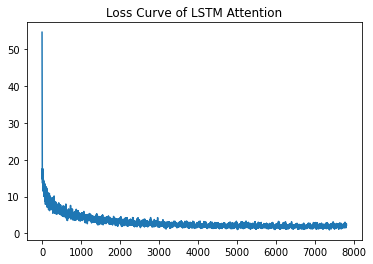

In [170]:
plt.plot(np.arange(len(lstm_loss_list)), lstm_loss_list)
plt.title('Loss Curve of LSTM Attention')

Test the accuracy of your model. You should be able to get at least 68% accuracy.

In [171]:
def comp_acc(pred, gt, valid_len):
  N, T_gt = gt.shape[:2]
  _, T_pr = pred.shape[:2]
  assert T_gt == T_pr, 'Prediction and target should have the same length.'
  len_mask = torch.arange(T_gt).expand(N, T_gt)
  len_mask = len_mask < valid_len[:, None]
  
  pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
  pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
  return pred_acc
  
def evaluate_lstm(net, train_iter, device):
  acc_list = []
  for i, train_data in enumerate(train_iter):
    train_data = [ds.to(device) for ds in train_data]

    pred = net.predict(*train_data)

    pred_acc = comp_acc(pred.detach().cpu(), train_data[2].detach().cpu()[:, 1:], train_data[3].cpu())
    acc_list.append(pred_acc)
    if i < 5:# print 5 samples from 5 batches
      pred = pred[0].detach().cpu()
      pred_seq = []
      for t in range(MAX_LEN+1):
        pred_wd = vocab_fra.index2word[pred[t].item()] 
        if pred_wd != 'eos':
          pred_seq.append(pred_wd)

      print('pred:\t {}\n'.format(pred_seq))
      print('tgt:\t {}\n'.format([vocab_fra.index2word[t.item()] for t in train_data[2][0][1:].cpu()]))

  print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))
  
seed(1)
batch_size = 32

vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)
evaluate_lstm(lstm_net, train_iter, device)

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
pred:	 ['unk', '.', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']

tgt:	 ['unk', '!', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ["j'en", 'ai', 'peur', '.', 'pad', 'pad', 'pad', 'pad']

tgt:	 ['je', "t'en", 'dois', 'une', '.', 'eos', 'pad', 'pad', 'pad']

pred:	 ['a-t-il', 'raison', '?', 'pad', 'pad', 'pad', 'pad', 'pad']

tgt:	 ['est-il', 'unk', '?', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['je', 'suis', 'unk', '.', 'pad', 'pad', 'pad', 'pad']

tgt:	 ['je', 'suis', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['demande', 'à', 'quiconque', '!', 'pad', 'pad', 'pad', 'pad']

tgt:	 ['demande', 'à', 'unk', 'qui', '!', 'eos', 'pad', 'pad', 'pad']

Prediction Acc.: 0.9002


## Transformers

Recurrent Neural Networks can capture long-range, variable-length sequential information, but updating the current state relies on the previous states. Thus it cannot be parallelized across the entire sequence. In contrast, CNNs are easy to parallelize but they cannot capture sequential dependency within variable-length sequences and their receptive field is limited. Transformers resolve this dilemna by being able to capture long-range dependencies while also being easy to parallelize.

Transformers consist of several different components and we will walk you through each of them. The original paper can be found [here](https://arxiv.org/pdf/1706.03762.pdf). [Here](http://jalammar.github.io/illustrated-transformer/) is a very informative blog about transformers that should also be a good reference.

**Multi-Head Self-Attention**

Multi-head self-attention is an extension of the dot-product attention we've previously implemented. The "self-attention" part means that the query, key, and value all come from the same sequence. For a sentence, this means that we are looking at how each word pays attention to other words in the same sentence. The "multi-head" part means instead of only having one attention map, we can have multiple. This means that for a given word in the sentence, it can pay attention to different parts of the sentence.

The steps in the multi-head attention can be summarzied by the following steps:

   1. The multi-head self-attention takes the initial query $Q$, key $K$, and value $V$ as input. Note that, if not provided specifically, usually these are set to the same input embeddings $X=Q=K=V$ initially.
   
   1. Then, a linear projection is applied to $Q,K,V$ sepearately for each head $i=1,\dots,h$. 
      $$
   Q_i = QW^{Q}_i, K_i = KW^{K}_i, V_i = VW^{V}_i, i \in [0, \dots, h-1],
   $$
   
   where $W^Q_i \in \mathcal{R}^{d_{model} \times d_k}, W^K_i \in \mathcal{R}^{d_{model} \times d_k}\text{, and } W^V_i \in \mathcal{R}^{d_{model} \times d_v}$.
     
   1. Apply the scaled dot-product attention to each of these projected set of queries, keys, and values:
   $$
   \text{head}_i = \text{Attention}(Q_i, K_i, V_i) = \text{softmax}(\frac{Q_iK^T_i}{\sqrt{d_k}})V_i
   $$
   
   1. Concatenate all the heads together and project it with another learned linear projections: 
   
   $$
   \text{O} = \text{Concate(head}_1, \dots, \text{head}_h) \\
   \text{MultiHead}(Q, K, V) = \text{O}W^o, \hspace{10mm} \text{where } W^o \in \mathcal{R}^{{hd_v} \times d_{model}}
   $$

A good visualization from the above referenced [blog](http://jalammar.github.io/illustrated-transformer/) is shown below. Transformer stacks several multi-head attention modules together. For the first multi-head layer, the input is from the dataset, so an additional embedding layer is needed to project the input sequence into the appropriate dimensions. For subsequent layers, the output from the layer previous layer is directly used as input.

<div>
    <img src="http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png" width="600"/>
</div>

Image source: http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png

Implement the MultiHeadAttention class below:
 - Complete the __init__() function, where the linear mappings for query, key, values, and output should be created.
 - Complete the forward() function, where the multi-head attention is performed.

In [172]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, dk, num_heads,  **kwargs):
    super(MultiHeadAttention, self).__init__()
    """
    Inputs:
      d_model: int, the same d_model in paper, feature dimension of query/key/values
      d_k: int, feature projected dimension of query/key/value, we follow the setting in the paper, where d_v=d_k=d_q
      num_heads: int, number of heads used for this MultiHeadAttention
    """
    self.num_heads = num_heads
    self.attention = DotProductAttention()
    ##############################################################################
    # TODO: Initialize the linear mappings for the query, key, and values.
    # Also initialize the weight matrix for the output.
    ##############################################################################
    # Replace "pass" statement with your code
    self.w_q = nn.Linear(d_model, dk * num_heads, bias = False)
    self.w_k = nn.Linear(d_model, dk * num_heads, bias = False)
    self.w_v = nn.Linear(d_model, dk * num_heads, bias = False)
    self.w_o = nn.Linear(dk * num_heads, d_model, bias = False)
    # END OF YOUR CODE

  def forward(self, query, key, value, valid_length):
    """
    inputs:
      query: tensor of size (B, T, d_model)
      key: tensor of size (B, T, d_model)
      value: tensor of size (B, T, d_model)
      valid_length: (B, )

      B is the batch_size, T is length of sequence, d_model is the feature dimensions of query,
      key, and value.

    Outputs:
      attention (B, T, d_model)
      """
    ##############################################################################
    # TODO: Implement the forward pass of MultiHeadAttention.
    ##############################################################################
    # Replace "pass" statement with your code
    def tpose(ten, num_heads, mode):

      if mode == 0:
        out = ten.reshape(ten.shape[0], ten.shape[1], num_heads, -1)
        out = out.permute(0, 2, 1, 3)
        return out.reshape(-1, out.shape[2], out.shape[3])
      else:
        out = ten.reshape(-1, num_heads, ten.shape[1], ten.shape[2])
        out = out.permute(0, 2, 1, 3)
        return out.reshape(out.shape[0], out.shape[1], -1)  

    query = self.w_q(query)
    query = tpose(query, self.num_heads, 0)
    key = tpose(self.w_k(key), self.num_heads, 0)
    value = tpose(self.w_v(value), self.num_heads, 0)
    
    if valid_length is not None:
      if valid_length.ndim == 1:
        valid_length = valid_length.repeat(self.num_heads)
      else:
        valid_length = valid_length.repeat(self.num_heads, 1)
    attention = tpose(self.attention(query, key, value, valid_length), self.num_heads, 1)
    # print(attention)
    # print(attention.shape)
    attention = self.w_o(attention)
    # END OF YOUR CODE

    return attention

In [173]:
cell = MultiHeadAttention(5, 90, 9)
X = torch.ones((2, 4, 5))
valid_len = torch.tensor([2, 3])
cell(X, X, X, valid_len).shape

torch.Size([2, 4, 5])

### Position-wise Feed-Forward Network

Another key component in the Transformer block is the position-wise feed-forward network (FFN). It's called position-wise FFN because the linear mapping is applied to each position separately and identically. For example, for an embedded input of size $N \times T \times D_{in}$, there are $N*T$ vectors of dimension $D_{in}$. If we apply a one layer position-wise FFN with weights of size $D_{in} \times D_{out}$. The linear projection will be applied to each of the $N*T$ vectors separately and identically. Thus, the output would have size $N \times T \times D_{out}$. Another way to think about this is that this is the same as a 1x1 convolution mapping from $D_{in}$ channels to $D_{out}$ channels.

Transformers stack two layers of position-wise FFN together, with a ReLU activation in between:

$$
\text{PositionWiseFFN}(x) = \text{max}(0, xW_1 + b_1)W_2 + b_2
$$

Complete the class PositionWiseFFN:

- Complete the __init__() function, where two position-wise FFN should be created.
- Complete the forward() function.

In [174]:
class PositionWiseFFN(nn.Module):
  def __init__(self, input_size, ffn_l1_size, ffn_l2_size):
    super(PositionWiseFFN, self).__init__()
    """
    Inputs:
      input_size: int, feature dimension of the input
      fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
      fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
    """
    ##############################################################################
    # TODO: Initialize the feed forward network for PositionWiseFFN
    ##############################################################################
    # Replace "pass" statement with your code
    self.lin1 = nn.Linear(input_size, ffn_l1_size)
    self.relu = nn.ReLU()
    self.lin2 = nn.Linear(ffn_l1_size, ffn_l2_size)
    # END OF YOUR CODE

  def forward(self, X):
    """
    Input:
      X: tensor of size (N, T, D_in)
    Output:
      o: tensor of size (N, T, D_out)
    """
    o = None
    ##############################################################################
    # TODO: Implement forward pass of PositionWiseFFN
    ##############################################################################
    # Replace "pass" statement with your code
    o = self.lin2(self.relu(self.lin1(X)))
    # END OF YOUR CODE
    return o



Check your result. Expected output

```
[[ 0.1609,  0.0371,  0.4916,  0.1781,  0.2010,  0.0161,  0.0869, -0.1879],
        [ 0.1609,  0.0371,  0.4916,  0.1781,  0.2010,  0.0161,  0.0869, -0.1879],
        [ 0.1609,  0.0371,  0.4916,  0.1781,  0.2010,  0.0161,  0.0869, -0.1879]]
```

In [175]:
seed(1)
ffn = PositionWiseFFN(4, 4, 8)
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.1609,  0.0371,  0.4916,  0.1781,  0.2010,  0.0161,  0.0869, -0.1879],
        [ 0.1609,  0.0371,  0.4916,  0.1781,  0.2010,  0.0161,  0.0869, -0.1879],
        [ 0.1609,  0.0371,  0.4916,  0.1781,  0.2010,  0.0161,  0.0869, -0.1879]],
       grad_fn=<SelectBackward0>)

### Positional Encoding

Replacing RNNs with the multi-head attention layer and applying the position-wise feed-forward network makes the computation parallelizable since these modules compute the output of each item in the sequence independently. However, since every item is processed in parallel, there is no notion of ordering of the sequence. For an input sentence, this means that the transformer doesn't know the ordering of the words in the sentence. For most tasks, this ordering is very important. To address this, transformers propose adding a positional encoding to each input that corresponds to the position in the sequence. This means that we take the position of each word in the sentence (eg. 0, 1, 2, etc...) and map it to some $d_{model}$-dimensional embedding. We then add this embedding with every input item so that the input is not position-aware. Transformers use the following sinusoidal positional encoding:

$$
\begin{align*}
PE_{(pos, 2i)} &= sin(pos / 10000^{2i/d_{model}}) \\
PE_{(pos, 2i+1)} &= cos(pos / 10000^{2i/d_{model}}) 
\end{align*}
$$

An example borrowed from this [blog](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) can give an ituition how this positional encoding works. Suppose you want to encode the number from $0$ to $8$ using binary encoding, the result would like this:
$$
\begin{align*}
0: && 0  0  0 \\
1: && 0  0  1 \\
2: && 0  1  0 \\
3: && 0  1  1 \\
4: && 1  0  0 \\
5: && 1  0  1 \\
6: && 1  1  0 \\
7: && 1  1  1 \\
\end{align*}
$$
Note the frequency of ones in each digit is different. Thus, words at different locations will have different embedding features (digits in the example). The figure below visualized a position encoding matrix of dimension $\mathcal{R}^{50 \times 128}$

The forward pass of the positional encoding should add the positional embedding to the input:

`y = x + positional_encoding(x)`

<div>
    <img src="https://d33wubrfki0l68.cloudfront.net/ef81ee3018af6ab6f23769031f8961afcdd67c68/3358f/img/transformer_architecture_positional_encoding/positional_encoding.png" width="600"/>
</div>

Image source: https://d33wubrfki0l68.cloudfront.net/ef81ee3018af6ab6f23769031f8961afcdd67c68/3358f/img/transformer_architecture_positional_encoding/positional_encoding.png

Complete the class PositionalEncoding:
- Complete the __init__() function, where the tensor $PE$ should be created.
- Complete the forward() function.

In [176]:
class PositionalEncoding(nn.Module):
  def __init__(self, dim, device, max_len=1000):
    super(PositionalEncoding, self).__init__()
    """
    Inputs:
      dim: feature dimension of the positional encoding
    """
    ##############################################################################
    # TODO: Initialize positional encoding. You should create `self.pe`
    # here according to the definition above. The positional encoding should
    # support up to position `max_len`.
    ##############################################################################
    # Replace "pass" statement with your code
    self.p = torch.zeros((1, max_len, dim))
    x = torch.arange(0, max_len, dtype = torch.float32).reshape(-1, 1)
    x = x / torch.pow(10000, torch.arange(0, dim, 2, dtype = torch.float32) / dim)
    
    self.p[:, :, 0::2] = torch.sin(x)
    self.p[:, :, 1::2] = torch.cos(x)
    # END OF YOUR CODE


  def forward(self, X):
    """
    Inputs:
      X: tensor of size (N, T, D_in)
    Output:
      Y: tensor of the same size of X
    """
    Y = None
    ##############################################################################
    # TODO: Implement forward pass for positional encoding. After getting the positional
    # encoding with regards to the time dimension, add it to the input X.
    ##############################################################################
    # Replace "pass" statement with your code
    Y = X + self.p[:, :X.shape[1], :].to(X.device)
    # END OF YOUR CODE

    return Y

Check your result. Expected output

```
[[1., 2., 1., 2., 1., 2., 1., 2., 1., 2.]]
```

In [177]:
seed(1)
pe = PositionalEncoding(10, device)
pe(torch.ones((2, 1, 10), device=device))[0]

tensor([[1., 2., 1., 2., 1., 2., 1., 2., 1., 2.]])

### Add and Norm

Transformers use a residual connection followed by a layer normalization layer to connect the inputs and outputs of other layers. To be specific, an "add and norm" layer is appended after each multi-head attention layer and the position-wise FFN layer. *The code for AddNorm Layer is given as below.*

In [178]:
class AddNorm(nn.Module):
    def __init__(self, dropout, embedding_size):
        super(AddNorm, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(embedding_size)

    def forward(self, X, Y):
        return self.norm(self.dropout(Y) + X)

### Encoder and Decoder

The following figure gives a simple example of how the Transformer is built on these components introduced above. It's easy to see that the encoder of the Transformer consists of several identical encoder blocks, and so does the decoder.

<div>
<img src="http://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png" width="600"/>
</div>

Image source: http://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png

Complete the forward() function for the EncoderBlock and DecoderBlock. Note that, for the decoder, when applying self-attention, the sequential queries **cannot** attend to those at later time steps. For example, in a sequence, the query entry at time step 5 can only observe the first 5 entries. You can use `valid_length` to enforce this.


In [179]:
class EncoderBlock(nn.Module):
  def __init__(self, d_model, d_k, ffn_l1_size, ffn_l2_size, num_heads, dropout):
    super(EncoderBlock, self).__init__()
    """
    Inputs:
      d_model: int, feature dimension of query/key/value
      d_k: int, feature projected dimension of query/key/value, we follow the setting in the paper, where d_v=d_k=d_q
      fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
      fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
      num_heads: int, number of head for multi-head attention layer.
      dropout: dropout probability for dropout layer.
      
    """
    self.attention = MultiHeadAttention(d_model, d_k, num_heads)
    self.addnorm_1 = AddNorm(dropout, d_model)
    self.ffn = PositionWiseFFN(d_model, ffn_l1_size, ffn_l2_size)
    self.addnorm_2 = AddNorm(dropout, d_model)

  def forward(self, X, valid_length):
    """
    Inputs:
      X: tensor of size (N, T, D), embedded input sequences
      valid_length: tensor of size (N), valid lengths for each sequence
    """
    Y = None
    ##############################################################################
    # TODO: Implement forward pass for the EncoderBlock. Use the figure above
    # for guidance:
    # attention -> add+norm -> feed forward -> add+norm
    ##############################################################################
    # Replace "pass" statement with your code
    Y = self.addnorm_1(X, self.attention(X, X, X, valid_length))
    Y = self.addnorm_2(Y, self.ffn(Y))
    # END OF YOUR CODE

    return Y

In [180]:
class DecoderBlock(nn.Module):
  def __init__(self, d_model, d_k, ffn_l1_size, ffn_l2_size, num_heads,
             dropout, **kwargs):
    super(DecoderBlock, self).__init__()
    """
    Inputs:
      d_model: int, feature dimension of query/key/value
      d_k: int, feature projected dimension of query/key/value, we follow the setting in the paper, where d_v=d_k=d_q
      fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
      fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
      num_heads: int, number of head for multi-head attention layer.
      dropout: dropout probability for dropout layer.
      
    """
    self.attention_1 = MultiHeadAttention(d_model, d_k, num_heads)
    self.addnorm_1 = AddNorm(dropout, d_model)
    self.attention_2 = MultiHeadAttention(d_model, d_model, num_heads)
    self.addnorm_2 = AddNorm(dropout, d_model)
    self.ffn = PositionWiseFFN(d_model, ffn_l1_size, ffn_l2_size)
    self.addnorm_3 = AddNorm(dropout, d_model)

  def forward(self, X, **kwargs):
    """
    Inputs:
      X: tensor of size (N, T, D), embedded input sequences
      **kwargs: other arguments you think is necessary for implementation
    Outputs:
      Y: tensor of size (N, T, D_out)
      
      Feel free to output variables if necessary.
    """
    Y = None
    ##############################################################################
    # TODO: Implement forward pass for the DecoderBlock. Use the figure above
    # for guidance:
    # self attention -> add+norm -> enc-dec attention -> add+norm -> feed forward -> add+norm
    # for the first attention layer, make sure to construct a `valid_length` that
    # ensures each element cannot attend to later elements in the sequence.
    ##############################################################################
    # Replace "pass" statement with your code
    state = kwargs['state']
    encoder_valid_len, encoder_outputs = state[0], state[1]

    # masking stuff from book

    # if state[2][i] is None:
    #   temp = X
    # else:
    #   temp = torch.concat((state[2][i], X), axis=1)
    # state[2][i] = temp
    # valid_len = None
    # if train:

    batch_size, seq_len, _ = X.shape
    valid_len = torch.arange(1, seq_len+1, device = X.device).repeat(batch_size, 1)

    # n1 = self.addnorm_1(X, torch.zeros_like(X))
    # alternatively try 3 n1 inputs instead of n1, temp, temp
    a1 = self.attention_1(X, X, X, valid_len)
    n1 = self.addnorm_1(X, a1)
    a2 = self.attention_2(n1, n1, n1, encoder_valid_len)
    n2 = self.addnorm_2(n1, a2)
    Y = self.addnorm_3(n2, self.ffn(n2))
    # END OF YOUR CODE

    return Y

### Transformer  Implementation

By stacking two encoder blocks and two decoder blocks, build the Transformer using the above components. 

- Implement the Encoder of Transformer:
 - Complete the __init__() function with a word embedding layer and several EncoderBlocks.
 - Complete the forward() function
- Implement the Decoder of Transformer
 - Complete the __init__() function
 - Complete the forward() function
- Implement the Transformer
 - Complete the forward() function
 - Complete the predict() function


In [181]:
class TransformerEncoder(nn.Module):
  def __init__(self, vocab_size, d_model, ffn_l1_size, ffn_l2_size,
               num_heads, num_layers, dropout, device):
    super(TransformerEncoder, self).__init__()
    """
    Inputs:
      d_model: int, feature dimension of query/key/value
      fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
      fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
      num_heads: int, number of head for multi-head attention layer.
      dropout: dropout probability for dropout layer.
      num_layers: number of encoder blocks
    """
    ##############################################################################
    # TODO: Implement init() function for TransformerEncoder. See forward() notes
    # for more details.
    ##############################################################################
    # Replace "pass" statement with your code
    self.num_layers = num_layers
    # self.num_hiddens = d_model*num_heads
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_enc = PositionalEncoding(d_model, dropout)
    self.enc_blks = nn.Sequential()
    self.d_model = d_model

    for i in range(num_layers):
      self.enc_blks.add_module("encoder block "+str(i), EncoderBlock(d_model, d_model//num_heads, ffn_l1_size, ffn_l2_size, num_heads, dropout))
    # END OF YOUR CODE

  def forward(self, X, valid_length):
    ##############################################################################
    # TODO: Implement forward pass for the TransformerEncoder
    # First, use an embedding so each element in X is d_model (hint: use nn.Embedding)
    # Then, apply the positional embedding to each element
    # Lastly, pass the resulting input into num_layers of EncoderBlocks
    ##############################################################################
    # Replace "pass" statement with your code
    X = self.pos_enc(self.embedding(X) * (self.d_model**0.5))
    for blk in self.enc_blks:
        X = blk(X, valid_length)
    # END OF YOUR CODE

    return X

In [182]:
class TransformerDecoder(nn.Module):
  def __init__(self, vocab_size, d_model, ffn_l1_size, ffn_l2_size,
             num_heads, num_layers, dropout, device):
    super(TransformerDecoder, self).__init__()
    """
    Inputs:
      d_model: int, feature dimension of query/key/value
      fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
      fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
      num_heads: int, number of head for multi-head attention layer.
      dropout: dropout probability for dropout layer.
      num_layers: number of decoder blocks
    """
    ##############################################################################
    # TODO: Implement init() function for TransformerDecoder
    ##############################################################################
    # Replace "pass" statement with your code
    self.num_layers = num_layers
    self.num_hiddens = d_model
    self.embedding = nn.Embedding(vocab_size, self.num_hiddens)
    self.pos_enc = PositionalEncoding(self.num_hiddens, dropout)
    self.dec_blks = nn.Sequential()
    self.dense = nn.Linear(self.num_hiddens, vocab_size)


    for i in range(num_layers):
      self.dec_blks.add_module("encoder block "+str(i), DecoderBlock(d_model, d_model, ffn_l1_size, ffn_l2_size, num_heads, dropout))


    
    # END OF YOUR CODE


  def forward(self, X, state):
    """
    Inputs:
      X: tensor of size (N, T, D), embedded input sequences
      valid_length: tensor of size (N,), valid lengths for each sequence
    """
    ##############################################################################
    # TODO: Implement forward pass for the TransformerDecoder. This will look
    # very similar to the TransformerEncoder.
    ##############################################################################
    # Replace "pass" statement with your code
    X = self.pos_enc(self.embedding(X) * (self.num_hiddens**0.5))
    kwargs = {'state':state}
    for blk in self.dec_blks:
        X = blk(X, **kwargs)
    # END OF YOUR CODE
    return self.dense(X), X

In [183]:
class Transformer(nn.Module):
  """The base class for the encoder-decoder architecture."""
  def __init__(self, encoder, decoder, **kwargs):
    super(Transformer, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, src_array, src_valid_len, tgt_array, tgt_valid_len):
    """Forward function"""
    loss = 0
    pred = None
    ##############################################################################
    # TODO: Implement forward pass of transformer
    ##############################################################################
    # Replace "pass" statement with your code
    T = tgt_array.shape[1]
    state = (src_valid_len, self.encoder(src_array, src_valid_len))
    pred, _ = self.decoder(tgt_array, state)

    for t in range(T-1):
      loss += F.nll_loss(F.log_softmax(pred[:,t]), tgt_array[:,t+1], ignore_index = 0)
    pred = pred.argmax(dim = -1)
    # END OF YOUR CODE
    return loss, pred
        
  def predict(self, src_array, src_valid_len, tgt_array, tgt_valid_len):
    pred = None
    ##############################################################################
    # TODO: Implement predict() of transformer
    ##############################################################################
    # Replace "pass" statement with your code
    state = []
    state.append(src_valid_len)
    state.append(self.encoder(src_array, src_valid_len))
    pred = torch.clone(tgt_array)
    for t in range(MAX_LEN-1):
      x_t, _ = self.decoder(pred, state)
      x_t = x_t.argmax(dim = -1)
      pred[:, t] = x_t[:, t]
    pred = pred[:,:-1]
    # END OF YOUR CODE
    return pred



Find a good learning rate for training this model. Feel free to tune other hyperparameters as well as long as your best model is saved in `transformer_net`.

In [184]:
def train_transformer(net, train_iter, lr, epochs, device):
  # training
  #net = net.to(device)

  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  loss_list = []
  print_interval = len(train_iter)
  total_iter = epochs * len(train_iter)
  for e in range(epochs):
    net.train()
    for i, train_data in enumerate(train_iter):
      train_data = [ds.to(device) for ds in train_data]

      loss, pred = net(*train_data)

      #loss_list.append(loss.mean().detach())
      loss_list.append(loss.mean().detach().cpu())
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()

      step = i + e * len(train_iter)
      if step % print_interval == 0:
        print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.mean().detach()))
        print('pred:\t {}\n'.format(pred[0].detach().cpu()))
        print('tgt:\t {}\n'.format(train_data[2][0][1:].cpu()))
  return loss_list


# hyper-params: feel free to modify the values and numbers of hyper-params 

# training
seed(1)
batch_size = 32
vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)

embedding_dim = 250
hidden_size = 128

#transformer hp
d_model = 64
ffn_l1_size = 128
ffn_l2_size = d_model
num_heads = 8
num_layers = 6
dropout = 0.1

lr = None
##############################################################################
# TODO: Find a good learning rate to train this model. Make sure your best
# model is saved to the `transformer_net` variable. Feel free to tune other hyperparameters
# as well.
##############################################################################
# Replace "pass" statement with your code
lr = 0.00146
# END OF YOUR CODE
epochs = 50

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu") # cuda:0 if you have gpu

encoder = TransformerEncoder(vocab_eng.num_word, d_model, ffn_l1_size, ffn_l2_size,
                             num_heads, num_layers, dropout, device=device)
decoder = TransformerDecoder(vocab_fra.num_word, d_model, ffn_l1_size, ffn_l2_size,
                             num_heads, num_layers, dropout, device=device)
transformer_net = Transformer(encoder, decoder)

transformer_loss_list = train_transformer(transformer_net, train_iter, lr, epochs, device)

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
iter 0 / 7800	Loss:	49.422611
pred:	 tensor([209, 283,  34, 234, 412, 352, 352, 352, 352,   5])

tgt:	 tensor([ 3, 34,  5,  2,  0,  0,  0,  0,  0])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


iter 156 / 7800	Loss:	25.527851
pred:	 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

tgt:	 tensor([171,   3,   5,   2,   0,   0,   0,   0,   0])

iter 312 / 7800	Loss:	24.800997
pred:	 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

tgt:	 tensor([171, 342,   3,   5,   2,   0,   0,   0,   0])

iter 468 / 7800	Loss:	20.360918
pred:	 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

tgt:	 tensor([14, 28,  3, 11,  2,  0,  0,  0,  0])

iter 624 / 7800	Loss:	18.852787
pred:	 tensor([3, 3, 2, 2, 2, 2, 2, 2, 2, 2])

tgt:	 tensor([ 61, 107, 318,  70,   3,  11,   2,   0,   0])

iter 780 / 7800	Loss:	18.786978
pred:	 tensor([14,  3,  3,  2,  2,  2,  2,  2,  2,  2])

tgt:	 tensor([53,  3,  5,  2,  0,  0,  0,  0,  0])

iter 936 / 7800	Loss:	16.671423
pred:	 tensor([14,  3,  2,  2,  2,  2,  2,  2,  2,  2])

tgt:	 tensor([ 92, 341,   3,  11,   2,   0,   0,   0,   0])

iter 1092 / 7800	Loss:	18.475958
pred:	 tensor([14,  3,  2,  2,  2,  2,  2,  2,  2,  2])

tgt:	 tensor([ 37, 167, 175, 293,  24,   2,   0,   0,   0])

iter 12

Text(0.5, 1.0, 'Loss Curve of Transformer')

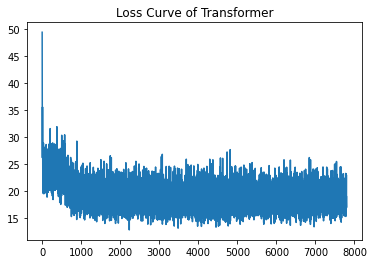

In [185]:
plt.plot(np.arange(len(transformer_loss_list)), transformer_loss_list)
plt.title('Loss Curve of Transformer')

Test the accuracy of your model. You should be able to get at least 73% accuracy.

In [186]:
def comp_acc(pred, gt, valid_len):
  N, T_gt = gt.shape[:2]
  _, T_pr = pred.shape[:2]
  assert T_gt == T_pr, 'Prediction and target should have the same length.'
  len_mask = torch.arange(T_gt).expand(N, T_gt)
  len_mask = len_mask < valid_len[:, None]
  
  pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
  pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
  return pred_acc
  
def evaluate_transformer(net, train_iter, device):
  net.eval()
  acc_list = []
  for i, train_data in enumerate(train_iter):
    train_data = [ds.to(device) for ds in train_data]

    pred = net.predict(*train_data)

    pred_acc = comp_acc(pred.detach().cpu(), train_data[2].detach().cpu()[:, 1:], train_data[3].cpu())
    acc_list.append(pred_acc)
    if i < 5:# print 5 samples from 5 batches
      pred = pred[0].detach().cpu()
      pred_seq = []
      for t in range(MAX_LEN+1):
        pred_wd = vocab_fra.index2word[pred[t].item()] 
        if pred_wd != 'eos':
          pred_seq.append(pred_wd)

      print('pred:\t {}\n'.format(pred_seq))
      print('tgt:\t {}\n'.format([vocab_fra.index2word[t.item()] for t in train_data[2][0][1:].cpu()]))

  print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))
  
seed(1)
batch_size = 32

vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)

evaluate_transformer(transformer_net, train_iter, device)

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
pred:	 ['unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'pad', 'pad']

tgt:	 ['unk', '!', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'pad', 'pad']

tgt:	 ['je', "t'en", 'dois', 'une', '.', 'eos', 'pad', 'pad', 'pad']

pred:	 ['unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'pad', 'pad']

tgt:	 ['est-il', 'unk', '?', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'pad', 'pad']

tgt:	 ['je', 'suis', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'pad', 'pad']

tgt:	 ['demande', 'à', 'unk', 'qui', '!', 'eos', 'pad', 'pad', 'pad']

Prediction Acc.: 0.1520
